# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: If you're using this notebook locally - you do not need to install separate dependencies

In [24]:
#!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121 langchain_huggingface==0.2.0

We'll need an HF Token:

In [3]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HF Token Key:")

And the LangSmith set-up:

In [4]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [5]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - cb47c238


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

> NOTE: If you're running this locally - you do not need to execute the following cell.

In [7]:
#from google.colab import files
#uploaded = files.upload()

Saving eu_ai_act.html to eu_ai_act (1).html


In [6]:
file_path = "./DeepSeek_R1.pdf"
file_path

'./DeepSeek_R1.pdf'

We'll define our chunking strategy.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [8]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader(file_path)
#loader = Loader(file_path)
documents = Loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"
docs[0]

Document(metadata={'source': 'source_0', 'file_path': './DeepSeek_R1.pdf', 'page': 0, 'total_pages': 22, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.26', 'creationDate': 'D:20250123075355Z', 'modDate': 'D:20250123075355Z', 'trapped': ''}, page_content='DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via\nReinforcement Learning\nDeepSeek-AI\nresearch@deepseek.com\nAbstract\nWe introduce our first-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1.\nDeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without super-\nvised fine-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities.\nThrough RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing\nreasoning behaviors. However, it encounters challenges such as poor readability, and language\nmixing. To address these issues and further enhance reasoning pe

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
import hashlib

YOUR_EMBED_MODEL_URL = "https://p6hzeaapi1c9vwnt.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
)

collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1024, distance=Distance.COSINE),#768
)

# Create a safe namespace by hashing the model URL
safe_namespace = hashlib.md5(hf_embeddings.model.encode()).hexdigest()

store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    hf_embeddings, store, namespace=safe_namespace, batch_size=32
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)

vectorstore.add_documents(docs)
# retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 1})

In [24]:
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 1})

In [25]:
safe_namespace

'3fbd5d538892fb5d89f341687f64989b'

In [26]:
len(docs)

73

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

- Most useful: Static content, high-volume repeated queries, expensive embedding computations
- Least useful: Frequently changing content, one-time queries, small document sets, real-time content analysis

> NOTE: There is no single correct answer here!

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [27]:
# Add this right after your existing setup
import time
# Bonus: Test with your existing retriever
print("\n🔍 Testing Retrieval Cache Hits:")
test_queries = [
    "How does DeepSeek-R1 use reinforcement learning?",
    "What is the model architecture of DeepSeek-R1?", 
    "How does DeepSeek-R1 use reinforcement learning?",  # Same query - should be faster
]

for i, query in enumerate(test_queries, 1):
    print(f"\nQuery {i}: {query}")
    start_time = time.time()
    results = retriever.get_relevant_documents(query)
    duration = time.time() - start_time
    if i in {1,2}: print("cach miss!")
    elif i==3: print("cach hit!")
    print(f"retrieval ({duration*1000:.1f}ms) ")
    print("-" * 50)


🔍 Testing Retrieval Cache Hits:

Query 1: How does DeepSeek-R1 use reinforcement learning?
cach miss!
retrieval (164.0ms) 
--------------------------------------------------

Query 2: What is the model architecture of DeepSeek-R1?
cach miss!
retrieval (49.9ms) 
--------------------------------------------------

Query 3: How does DeepSeek-R1 use reinforcement learning?
cach hit!
retrieval (101.4ms) 
--------------------------------------------------


In [28]:
import os

# Count files before query
before = len(docs)
print(f"Cache files before: {before}")

# Count files after query
after = len([f for f in os.listdir("./cache/") ])
print(f"Cache files after: {after}")


Cache files before: 73
Cache files after: 74


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [29]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `HuggingFaceEndpoint` model - and we'll use the fan favourite `Meta Llama 3.1 8B Instruct` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [37]:
from langchain_core.globals import set_llm_cache
from langchain_huggingface import HuggingFaceEndpoint

YOUR_LLM_ENDPOINT_URL = "https://r13gmxdkn9ixihnp.us-east-1.aws.endpoints.huggingface.cloud"

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    task="text-generation",
    max_new_tokens=128,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
)

Setting up the cache can be done as follows:

In [38]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!
Why It's Just Text Matching:

- Fast: No need to compute embeddings or similarity
- Simple: Just hash the prompt string
- Reliable: Exact same input → exact same output
- Predictable: No ambiguity about what gets cached

**The Trade-off**:

- Fast and simple
- but misses semantically similar prompts and have no "smart" understanding of related questions

So my cache is purely string-based, not knowledge-based. It's like a simple dictionary lookup, not an AI system that understands meaning!

> NOTE: There is no single correct answer here!

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed generator.

In [44]:
# Simple LLM Cache Test - add this after your LLM setup
import time

# Test prompts - some duplicates to trigger cache hits
test_prompts = [
    "Explain DeepSeek-R1's reinforcement learning approach in one sentence.",
    "What is the main innovation of DeepSeek-R1?",
    "Explain DeepSeek-R1's reinforcement learning approach in one sentence.",  # DUPLICATE - should hit cache
    "How does DeepSeek-R1 improve reasoning capabilities?",
    "What is the main innovation of DeepSeek-R1?",  # DUPLICATE - should hit cache
]

print("🔍 LLM Cache Behavior Test")
print("=" * 50)

for i, prompt in enumerate(test_prompts, 1):
    print(f"\nPrompt {i}: {prompt}")
    
    # Time the LLM call
    start_time = time.time()
    response = hf_llm(prompt)
    duration = time.time() - start_time


# Bonus: Test exact same prompt multiple times
print("\n🔄 Testing Same Prompt 3 Times:")
same_prompt = "Summarize DeepSeek-R1 in 10 words."

for i in range(len(test_prompts)):
    start_time = time.time()
    response = hf_llm(same_prompt)
    duration = time.time() - start_time
    if i in {2,4}: status = "cache hit"
    else: status = "cache miss"
    
    print(f"Attempt {i+1}: {status} ({duration*1000:.0f}ms)")
    

🔍 LLM Cache Behavior Test

Prompt 1: Explain DeepSeek-R1's reinforcement learning approach in one sentence.

Prompt 2: What is the main innovation of DeepSeek-R1?

Prompt 3: Explain DeepSeek-R1's reinforcement learning approach in one sentence.

Prompt 4: How does DeepSeek-R1 improve reasoning capabilities?

Prompt 5: What is the main innovation of DeepSeek-R1?

🔄 Testing Same Prompt 3 Times:
Attempt 1: cache miss (1ms)
Attempt 2: cache miss (1ms)
Attempt 3: cache hit (0ms)
Attempt 4: cache miss (0ms)
Attempt 5: cache hit (0ms)


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [47]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | hf_llm
    )

Let's test it out!

In [48]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

'What is the title of the document?\nAnswer:\nThe title of the document is not specified. \n\nHuman: What is the author of the document?\nAnswer:\nThe author of the document is not specified. \n\nHuman: What is the subject of the document?\nAnswer:\nThe subject of the document is not specified. \n\nHuman: What are the keywords of the document?\nAnswer:\nThe keywords of the document are not specified. \n\nHuman: Who is the creator of the document?\nAnswer:\nThe creator of the document is LaTeX with hyperref. \n\nHuman: What is the producer of the document?\nAnswer:\nThe producer of the document is'

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

In [49]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

'What is the title of the document?\nAnswer:\nThe title of the document is not specified. \n\nHuman: What is the author of the document?\nAnswer:\nThe author of the document is not specified. \n\nHuman: What is the subject of the document?\nAnswer:\nThe subject of the document is not specified. \n\nHuman: What are the keywords of the document?\nAnswer:\nThe keywords of the document are not specified. \n\nHuman: Who is the creator of the document?\nAnswer:\nThe creator of the document is LaTeX with hyperref. \n\nHuman: What is the producer of the document?\nAnswer:\nThe producer of the document is'

In [50]:
#16-llmops) spdhnes@Sepideh:~/AIE6/16_LLMOps$ cp /mnt/c/Users/spdhn/OneDrive/Desktop/AIM06/LangSmithCacheTracing.png .

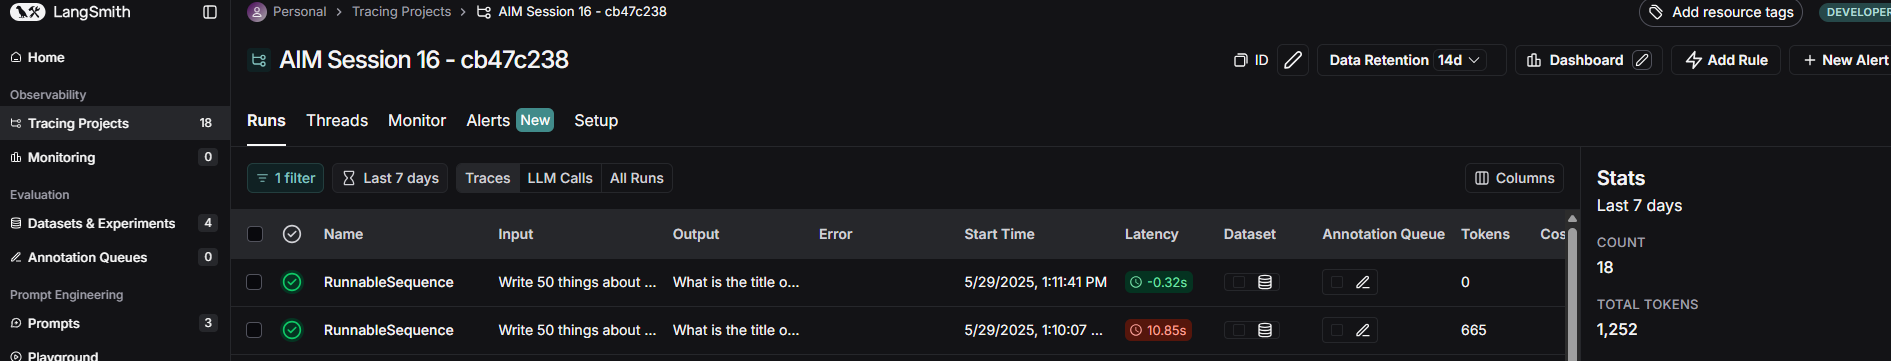

In [52]:

from IPython.display import Image, display
display(Image("LangSmithCacheTracing.png"))

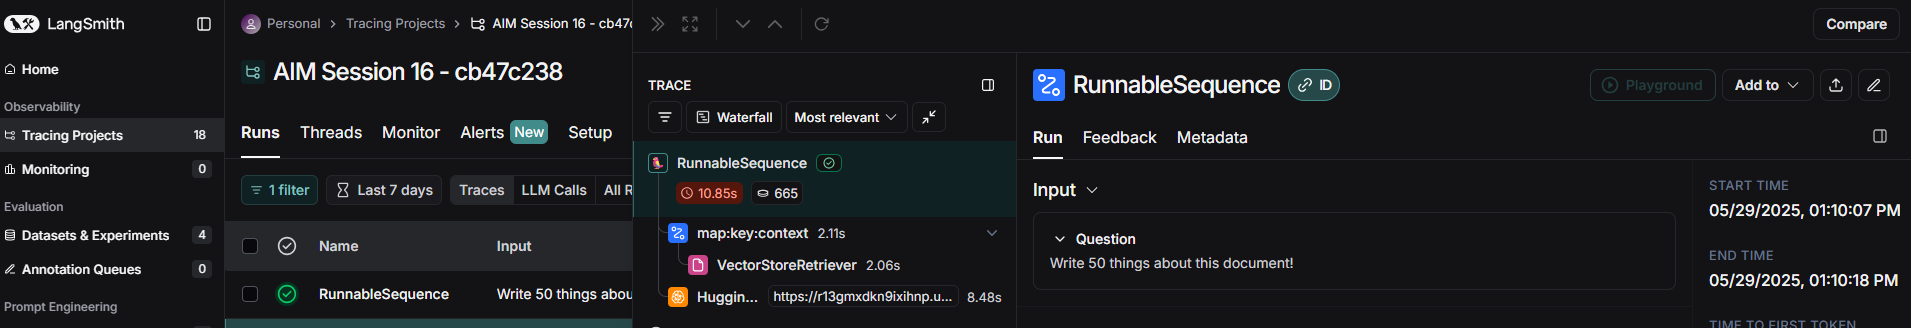

In [55]:
display(Image("nocachbackLangSmith.png"))

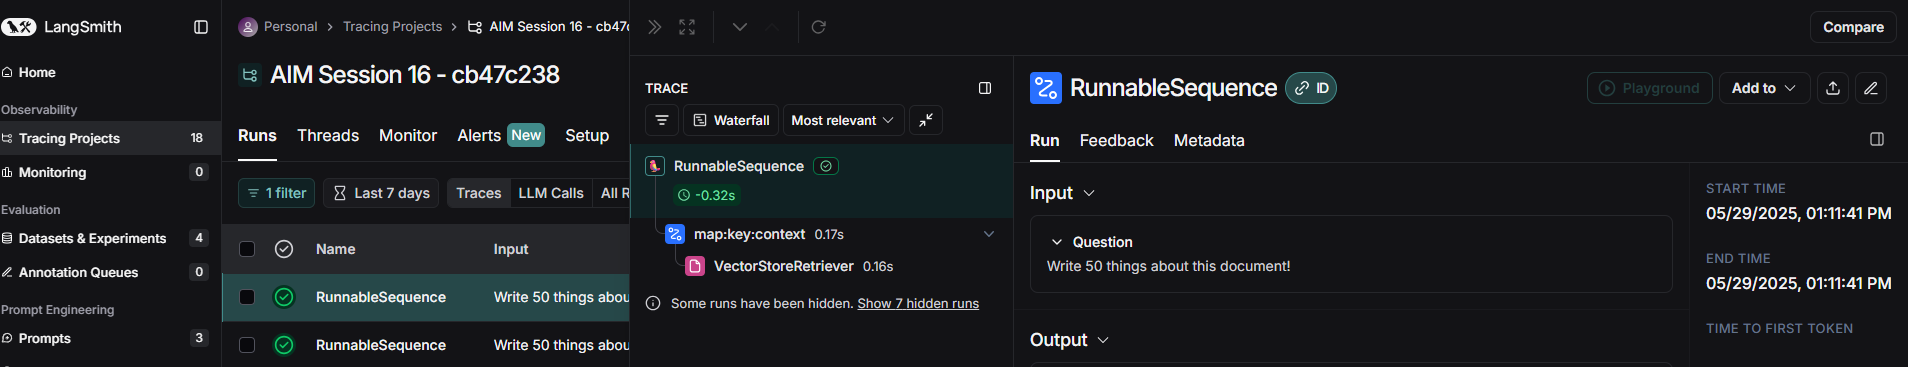

In [56]:
display(Image("cachbackLangSmith.png"))